To_do:

* Generate representations for each of the following
    * Bag of words
    * TFIDF: term frequency-inverse document frequency
    * CBOW
    * Word2Vec
* Perform PCA and LDA on various representations
    * Also apply MCA and compare to PCA
* run nearest neighbors on various representations and analyze cross dispensaries
    * look at some examples of elements that are close together 
* generate tsne
* Use cosine similarity/distance/etc.

Food for thought
* Think about the way we choose the number of dimensions (ie ``min_df``), make it so that the whole pipeline can be optimized with this in mind

Some questions
* Removing least common words from analysis is beneficial but can get rid of percentages, which is an important part of the data (ie thc 15%), could encode in a more efficient way

# Preprocessing

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from scipy.sparse import save_npz
import gensim

In [2]:
scraped_fn = 'datasets/190919ProductScrape291_subset.csv'
weed_text = pd.read_csv(scraped_fn)

In [3]:
weed_text.head()

,scrape_number,dispensary_name,license_type,address,city,state,product_name,classification,description,price_eighth
0,291,$100.00 Oz,medical,"San Marcos,CA 92069",San Marcos,CA,(Outdoor) Lucifer OG $59.99 oz,Indica,Lucifer OG by Karma Genetics is the devilish o...,0.0
1,291,$100.00 Oz,medical,"San Marcos,CA 92069",San Marcos,CA,(P.R.) Cake Batter OG $165oz,Indica,Soooooo frosty ! Pure Fire!! Get in while its ...,35.0
2,291,$100.00 Oz,medical,"San Marcos,CA 92069",San Marcos,CA,(Light Dep)Greasy Grapes $100oz,Indica,"This fast-acting strain delivers energizing, d...",0.0
3,291,$100.00 Oz,medical,"San Marcos,CA 92069",San Marcos,CA,(PR)Face Off OG $165.00oz,Indica,NaN,0.0
4,291,$100.00 Oz,medical,"San Marcos,CA 92069",San Marcos,CA,(Top) Cookie Jar $125 oz,Indica,Cookie Jar is a dessert blend ofPlatinum Girl ...,0.0


In [4]:
num_rows = weed_text.shape[0]
num_na = weed_text['description'].isna().sum()
num_dispensaries = weed_text['dispensary_name'].nunique()

print('number of NA in description {0}/{1}: {2:.4f}'.format(num_na, num_rows, num_na/num_rows))

number of NA in description 720475/1944293: 0.3706


In [5]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
# clean data (remove punctuation, dropna, etc.)
# manually remove stopwords and lemmatize
english_stopwords = set(stopwords.words('english'))
wnl = WordNetLemmatizer()
def fn(a):
    a = [wnl.lemmatize(t) for t in a.split() if t not in english_stopwords]
    return ' '.join(a)
clean_description = weed_text['description'].dropna()
clean_description = clean_description.str.replace('[!"#$&\'()*+,:;<=>?@[\\]^_`{|}~/-]', '')
clean_description = clean_description.str.lower()
clean_description = clean_description.str.strip()
clean_description = clean_description.apply(fn)
clean_description[:5]

KeyboardInterrupt: 

In [ ]:
cleaned_weed_text = weed_text.iloc[clean_description.index][['dispensary_name', 'description', 'product_name', 'price_eighth']]
cleaned_weed_text.head()

Note that ``min_df = 0.001`` may get rid of important information regarding thc content (ie thc 76.14%)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
desc_vectorizer = CountVectorizer(min_df = 0.001)
vec_desc = desc_vectorizer.fit_transform(clean_description)
vec_desc.shape
# save_npz('datasets/bag_of_words.npz', matrix = vec_desc)

In [ ]:
vec_desc

In [ ]:
save_npz('datasets/bag_of_words.npz', matrix = vec_desc)

In [ ]:
def count_perc(data, vocabulary):
    def calculate_found_and_total(sentence):
        split_sentence = sentence.split()
        found_words = [word for word in sentence.split() if word in vocabulary]
        return len(found_words), len(split_sentence)
    adj_data = data.apply(calculate_found_and_total)
    return np.sum(adj_data.apply(lambda x: x[0])) / np.sum(adj_data.apply(lambda x: x[1])) 
count_perc(clean_description, desc_vectorizer.vocabulary_)

In [ ]:
cleaned_weed_text.to_csv('datasets/cleaned_desc.csv')

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False)
tfid_desc = tf_transformer.fit_transform(vec_desc)

In [ ]:
save_npz('datasets/term_freq.npz', matrix = tfid_desc)

In [38]:
from gensim.sklearn_api import W2VTransformer
model = W2VTransformer(size=10, min_count=1, seed=1)
model.fit([clean_description])

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/jiwonkim/anaconda3/envs/weed_nlp/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/jiwonkim/anaconda3/envs/weed_nlp/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jiwonkim/anaconda3/envs/weed_nlp/lib/python3.5/site-packages/gensim/models/base_any2vec.py", line 211, in _worker_loop
    tally, raw_tally = self._do_train_job(data_iterable, job_parameters, thread_private_mem)
  File "/home/jiwonkim/anaconda3/envs/weed_nlp/lib/python3.5/site-packages/gensim/models/word2vec.py", line 821, in _do_train_job
    tally += train_batch_cbow(self, sentences, alpha, work, neu1, self.compute_loss)
  File "gensim/models/word2vec_inner.pyx", line 628, in gensim.models.word2vec_inner.train_batch_cbow
  File "/home/jiwonkim/anaconda3/envs/weed_nlp/lib/python3.5/site-packages/pandas/core/generic.py", line 1576, in __nonzero__
    .f

KeyboardInterrupt: 

In [6]:
from scipy.sparse import load_npz
tfid_desc = load_npz('datasets/term_freq.npz')
vec_desc = load_npz('datasets/bag_of_words.npz')

# Dimensionality/Features
## PCA
Currently does not work b/c of sparse matrix

In [42]:
from sklearn.preprocessing import StandardScaler
vec_desc_std = StandardScaler(with_mean=False).fit_transform(vec_desc)
tfid_desc_std = StandardScaler(with_mean=False).fit_transform(tfid_desc)

/home/jiwonkim/anaconda3/envs/weed_nlp/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
vec_desc_std

<1223818x3228 sparse matrix of type '<class 'numpy.float64'>'
	with 27768733 stored elements in Compressed Sparse Row format>

In [44]:
from sklearn.decomposition import PCA
pca_bow = PCA(n_components=3228)
pca_bow.fit(vec_desc_std)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [ ]:
pca_tfid = PCA(n_components=3228)
pca_tfid.fit(tfid_desc_std)

In [ ]:
plt.subplot(121)
plt.title("PCA Explained Variance for BOW")
plt.plot(np.cumsum(pca_bow.explained_variance_ratio_))
plt.subplot(122)
plt.title("PCA Explained Variance for TFID")
plt.plot(np.cumsum(pca_bow.explained_variance_ratio_))
plt.show()

## Truncated SVD
| number of components |  50  | 100 | 150 |
|----------------------|------|-----|-----|
|   explained variance | 0.35 | 0.50| tbd |


Note 150 components takes a long time. Benefit over PCA: PCA could potentially work but BOW and TFIDF create sparse matrices, which makes PCA unusable (b/c of large matrices). Plus, you do not need to standard scale using TruncatedSVD

In [7]:
from sklearn.decomposition import TruncatedSVD
tsvd_bow = TruncatedSVD(n_components=100)
tsvd_bow_npy = tsvd_bow.fit_transform(vec_desc)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)

In [8]:
tsvd_tfid = TruncatedSVD(n_components=100)
tsvd_tfid_npy = tsvd_tfid.fit_transform(tfid_desc)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)

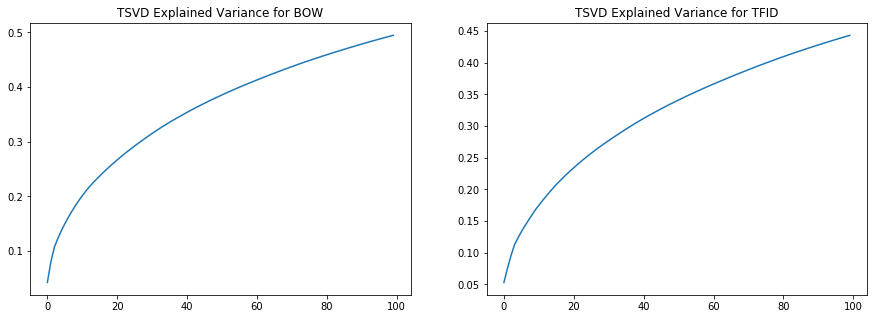

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("TSVD Explained Variance for BOW")
plt.plot(np.cumsum(tsvd_bow.explained_variance_ratio_))
plt.subplot(122)
plt.title("TSVD Explained Variance for TFID")
plt.plot(np.cumsum(tsvd_tfid.explained_variance_ratio_))
plt.show()

In [ ]:
from joblib import dump, load
dump(tsvd_bow, 'models/tsvd_bow.joblib')
dump(tsvd_tfid, 'models/tsvd_tfid.joblib')

np.save('datasets/tsvd_bow.npz', tsvd_bow_npy)
np.save('datasets/tsvd_tfid.npz', tsvd_tfid_npy)

## LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
search_params = {'n_components': [10, 15, 20, 25, 30]}

lda = LDA()
model = GridSearchCV(lda, param_grid = search_params)
model.fit(vec_desc)

# Clustering
## Kmeans
Note that kmeans cannot take in a sparse matrix, so it must be result of TruncatedSVD/LDA/etc, or you must convert to dense matrix. Interpretation of silhouette: compares average distance to other points within same cluster to that of the nearest other cluster (the higher the silhouette, the better the cluster

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
num_clusters = 10
kmeans_bow = [KMeans(n_clusters=x, random_state=0)
              for x in range(1, num_clusters + 1)]
silhou_bow = [0 for x in range(num_clusters)]
for i in range(num_clusters):
    print(i)
    cluster_labels = kmeans_bow[i].fit_transform(tsvd_bow_npy)
    silhou_bow[i] = silhouette_score(tsvd_bow_npy, np.ravel(cluster_labels))

0


/home/jiwonkim/anaconda3/envs/weed_nlp/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from joblib import dump, load
dump(kmeans_bow, 'models/kmeans_bow.joblib')
dump(silhou_bow, 'models/kmeans_bow_silh.joblib')

In [ ]:
num_clusters = 10
kmeans_tfid = [Kmeans(n_clusters=x, random_state=0)
               for x in range(1, num_clusters + 1)]
silhou_tfid = [0 for x in range(num_clusters)]
for i in range(num_clusters):
    cluster_labels = kmeans_tfid[i].fit(tsvd_tfid)
    silhou_tfid[i] = silhouette_score(tsvd_tfid, cluster_labels)